In [1]:
!pip install tensorflow-hub

In [7]:
!pip install tf_keras

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# Налаштування шляхів (використовуємо ті ж папки, що і в Лаб 9)
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'

# MobileNetV2 вимагає саме такий розмір [cite: 69]
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

print("Бібліотеки завантажено.")

Бібліотеки завантажено.


Dataset with variations created successfully!


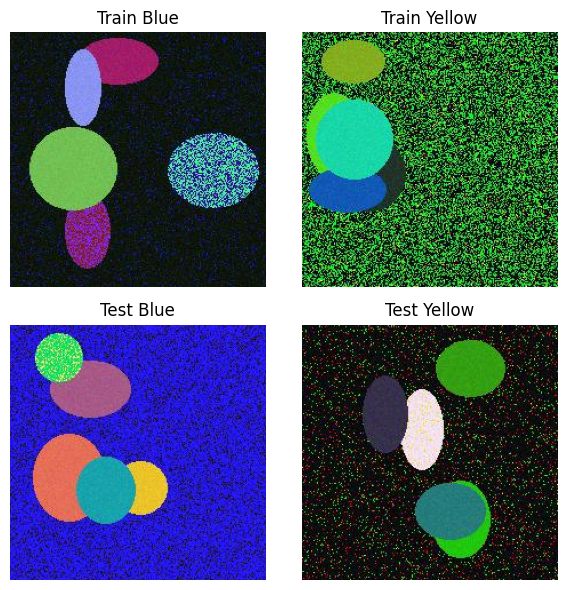

In [8]:
# Створення структури папок
folders = [
   "dataset/train/blue", "dataset/train/yellow",
   "dataset/test/blue",  "dataset/test/yellow"
]

for folder in folders:
   os.makedirs(folder, exist_ok=True)

def create_random_colored_image(base_color, path, size=(224, 224)):
   """
   base_color : tuple → (0,0,255) or (255,255,0)
   додаємо шум та випадкові форми, щоб дані не були однаковими
   """

   # створюємо фоновий колір з варіацією
   variation = np.random.randint(-40, 40, size=3)
   color = tuple(np.clip(np.array(base_color) + variation, 0, 255).astype(int))

   img = Image.new("RGB", size, tuple(color))
   draw = ImageDraw.Draw(img)

   # випадкові круги
   for _ in range(5):
      x1, y1 = np.random.randint(0, 150, size=2)
      x2, y2 = x1 + np.random.randint(30, 80), y1 + np.random.randint(30, 80)

      shape_color = tuple(np.random.randint(0, 255, size=3))
      draw.ellipse([x1, y1, x2, y2], fill=shape_color)

   # випадковий шум
   arr = np.array(img)
   noise = np.random.randint(0, 25, size=arr.shape, dtype='uint8')
   arr = np.clip(arr + noise, 0, 255)

   img = Image.fromarray(arr)
   img.save(path)

# Генеруємо тренувальні (100)
for i in range(100):
   create_random_colored_image((0,0,255), f"dataset/train/blue/blue_{i}.jpg")  # Синій
   create_random_colored_image((255,255,0), f"dataset/train/yellow/yellow_{i}.jpg") # Жовтий

# Генеруємо тестові (20)
for i in range(20):
   create_random_colored_image((0,0,255), f"dataset/test/blue/blue_{i}.jpg")    # Синій
   create_random_colored_image((255,255,0), f"dataset/test/yellow/yellow_{i}.jpg") # Жовтий

print("Dataset with variations created successfully!")

fig, axes = plt.subplots(2, 2, figsize=(6,6))

paths = [
   "dataset/train/blue/blue_0.jpg",
   "dataset/train/yellow/yellow_0.jpg",
   "dataset/test/blue/blue_0.jpg",
   "dataset/test/yellow/yellow_0.jpg",
]

titles = ["Train Blue", "Train Yellow", "Test Blue", "Test Yellow"]

for ax, path, title in zip(axes.flatten(), paths, titles):
   img = Image.open(path)
   ax.imshow(img)
   ax.set_title(title)
   ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
train_datagen = ImageDataGenerator(
   rescale=1./255,
   rotation_range=15,
   zoom_range=0.2,
   horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
   'dataset/train',
   target_size=(224, 224),
   batch_size=16,
   class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
   'dataset/test',
   target_size=(224, 224),
   batch_size=16,
   class_mode='binary'
)

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [10]:

model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Завантаження шару Hub
feature_extractor_layer = hub.KerasLayer(
    model_url,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    trainable=False
)

model = models.Sequential([
    feature_extractor_layer,
    layers.Dense(1, activation='sigmoid')
])

# Компіляція
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [11]:

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
13/13 [==============================] - 18s 938ms/step - loss: 0.6027 - accuracy: 0.6950 - val_loss: 0.5053 - val_accuracy: 0.8000
Epoch 2/5
13/13 [==============================] - 11s 785ms/step - loss: 0.3831 - accuracy: 0.8850 - val_loss: 0.3866 - val_accuracy: 0.9250
Epoch 3/5
13/13 [==============================] - 13s 929ms/step - loss: 0.2755 - accuracy: 0.9500 - val_loss: 0.3060 - val_accuracy: 0.9250
Epoch 4/5
13/13 [==============================] - 12s 880ms/step - loss: 0.2005 - accuracy: 0.9600 - val_loss: 0.2649 - val_accuracy: 0.9250
Epoch 5/5
13/13 [==============================] - 12s 901ms/step - loss: 0.1761 - accuracy: 0.9700 - val_loss: 0.2381 - val_accuracy: 0.9250


In [12]:
feature_extractor_layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy'])

print("Починаємо Fine-Tuning...")

# Донавчаємо ще 5 епох
history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Починаємо Fine-Tuning...
Epoch 1/5
13/13 [==============================] - 58s 3s/step - loss: 0.4922 - accuracy: 0.8400 - val_loss: 0.3277 - val_accuracy: 0.9250
Epoch 2/5
13/13 [==============================] - 39s 3s/step - loss: 0.3488 - accuracy: 0.9300 - val_loss: 0.3263 - val_accuracy: 0.9250
Epoch 3/5
13/13 [==============================] - 39s 3s/step - loss: 0.3115 - accuracy: 0.9250 - val_loss: 0.3141 - val_accuracy: 0.9250
Epoch 4/5
13/13 [==============================] - 39s 3s/step - loss: 0.2281 - accuracy: 0.9650 - val_loss: 0.2935 - val_accuracy: 0.9250
Epoch 5/5
13/13 [==============================] - 39s 3s/step - loss: 0.2220 - accuracy: 0.9700 - val_loss: 0.2674 - val_accuracy: 0.9250


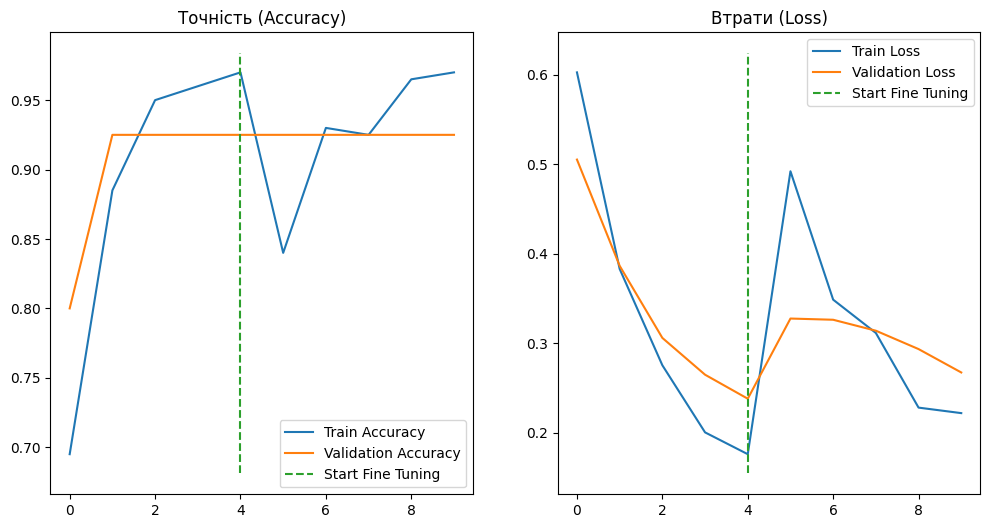

In [13]:
# Об'єднуємо історії навчання (щоб намалювати красивий графік)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Малюємо лінію, де почався Fine-Tuning
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Точність (Accuracy)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')
plt.show()

3/3 [==============================] - 4s 613ms/step
              precision    recall  f1-score   support

        blue       0.42      0.40      0.41        20
      yellow       0.43      0.45      0.44        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40



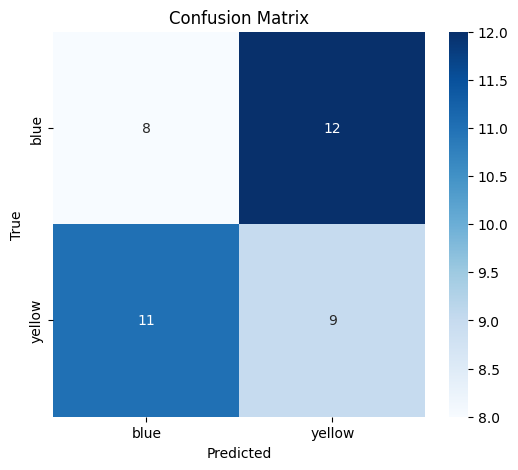

In [14]:
# Отримання прогнозів
test_data.reset()
predictions = model.predict(test_data, steps=len(test_data))
y_pred = (predictions > 0.5).astype("int32")
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Звіт [cite: 51]
print(classification_report(y_true, y_pred, target_names=class_labels))

# Матриця помилок [cite: 90]
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
learning_rates = [1e-3, 1e-4, 1e-5]
results = []

for lr in learning_rates:
   print(f"\nНавчання з LR={lr}")

   feature_extractor_layer.trainable = True
   model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss="binary_crossentropy",
      metrics=["accuracy"]
   )

   hist = model.fit(train_data, epochs=3, validation_data=test_data)
   acc = max(hist.history["val_accuracy"])

   results.append((lr, acc))

print("\nПорівняння:")
for lr, acc in results:
   print(f"LR={lr}: accuracy={acc:.4f}")


Навчання з LR=0.001
Epoch 1/3
13/13 [==============================] - 62s 3s/step - loss: 0.2103 - accuracy: 0.9550 - val_loss: 19.0512 - val_accuracy: 0.5000
Epoch 2/3
13/13 [==============================] - 40s 3s/step - loss: 0.1377 - accuracy: 0.9700 - val_loss: 33.0597 - val_accuracy: 0.5000
Epoch 3/3
13/13 [==============================] - 40s 3s/step - loss: 0.1029 - accuracy: 0.9900 - val_loss: 10.2693 - val_accuracy: 0.5750

Навчання з LR=0.0001
Epoch 1/3
13/13 [==============================] - 56s 3s/step - loss: 0.0861 - accuracy: 1.0000 - val_loss: 5.8050 - val_accuracy: 0.6000
Epoch 2/3
13/13 [==============================] - 39s 3s/step - loss: 0.0864 - accuracy: 1.0000 - val_loss: 3.1958 - val_accuracy: 0.7250
Epoch 3/3
13/13 [==============================] - 39s 3s/step - loss: 0.0855 - accuracy: 1.0000 - val_loss: 1.2060 - val_accuracy: 0.8500

Навчання з LR=1e-05
Epoch 1/3
13/13 [==============================] - 55s 3s/step - loss: 0.0845 - accuracy: 1.0000 - 